# Kaggle - Predict Future Sales

We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the next month. 

### Abstract

To predict the total amount of products sold in every shop we will do that based on the stores previous sales.

- I plan to use two different regression models; Random Forest Regression and XGBoost. Based on those models I plan to predict the future sales and submit my prediction on Kaggle. 

### Dependencies

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

### Colab requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/ADS/Assignment 2

/content/drive/My Drive/ADS/Assignment 2


In [ ]:
!pwd

/content/drive/My Drive/ADS/Assignment 2


### Importing Data From Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"swinalmeida","key":"f47f4cfddeea43b5506ce36e7beae083"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

items.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 449kB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 1.09MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [ ]:
!unzip test.csv.zip -d train
!unzip sales_train.csv.zip -d train
!unzip items.csv.zip -d train

Archive:  test.csv.zip
replace train/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  sales_train.csv.zip
replace train/sales_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  items.csv.zip
replace train/items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
sales_train = pd.read_csv('train/sales_train.csv')
items = pd.read_csv('train/items.csv')
shops = pd.read_csv('train/shops.csv')
item_categories = pd.read_csv('train/item_categories.csv')
test = pd.read_csv('train/test.csv')

### Data Files Description

sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

items.csv - supplemental information about the items/products.

item_categories.csv - supplemental information about the items categories.

shops.csv- supplemental information about the shops.

### Data Field Description

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

### Mapping Categories

In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
# Get english category names
categories = list(item_categories.item_category_name)

for i in range(0,8):
    categories[i] = 'Access'

for i in range(10,18):
    categories[i] = 'Consoles'

for i in range(18,25):
    categories[i] = 'Consoles Games'

for i in range(26,28):
    categories[i] = 'phone games'

for i in range(28,32):
    categories[i] = 'CD games'

for i in range(32,37):
    categories[i] = 'Card'

for i in range(37,43):
    categories[i] = 'Movie'

for i in range(43,55):
    categories[i] = 'Books'

for i in range(55,61):
    categories[i] = 'Music'

for i in range(61,73):
    categories[i] = 'Gifts'

for i in range(73,79):
    categories[i] = 'Soft'

item_categories['Category'] = categories
item_categories.head()

,item_category_name,item_category_id,Category
0,PC - Гарнитуры/Наушники,0,Access
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [ ]:
item_categories['item_category_name'].value_counts()

Аксессуары - PS2                          1
Подарки - Настольные игры (компактные)    1
Игры - PSP                                1
Подарки - Гаджеты, роботы, спорт          1
Подарки - Мягкие игрушки                  1
                                         ..
Программы - Обучающие (Цифра)             1
Карты оплаты - Live! (Цифра)              1
Игры - XBOX ONE                           1
Игры - PS2                                1
Аксессуары - PS3                          1
Name: item_category_name, Length: 84, dtype: int64

### Data Anaylsis and Feature Engineering

In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


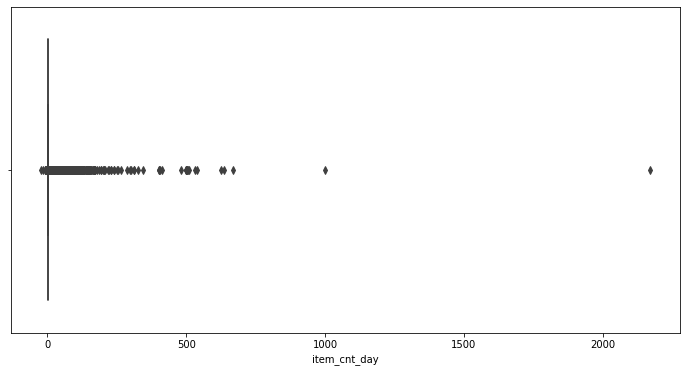

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(sales_train['item_cnt_day'])

From the above graph one can denote that item_cnt_day has an outlier thus we will only consider values less then 900 and it also has negative values

In [ ]:
sales_train[sales_train.item_cnt_day > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [ ]:
sales_train[sales_train.item_cnt_day > 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


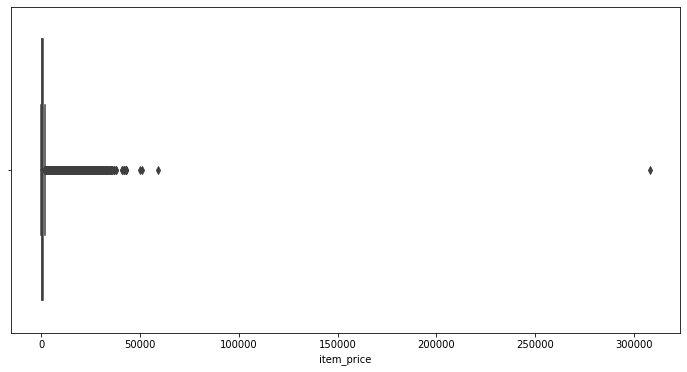

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(sales_train['item_price'])

From the above graph one can denote that item_price has an outlier thus we will only consider values without the outliers it also has negative values

In [ ]:
sales_train[sales_train.item_price > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [ ]:
sales_train[sales_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
# Dropping negative values
sales_train = sales_train[sales_train.item_price > 0].reset_index(drop=True)

# Dropping outliers values 
sales_train = sales_train[sales_train.item_price<100000] # drop 1
sales_train = sales_train[sales_train.item_cnt_day<1000] # drop 2

In [ ]:
sales_train.corr()['item_cnt_day'].sort_values

<bound method Series.sort_values of date_block_num    0.010298
shop_id          -0.005546
item_id           0.019340
item_price        0.013552
item_cnt_day      1.000000
Name: item_cnt_day, dtype: float64>

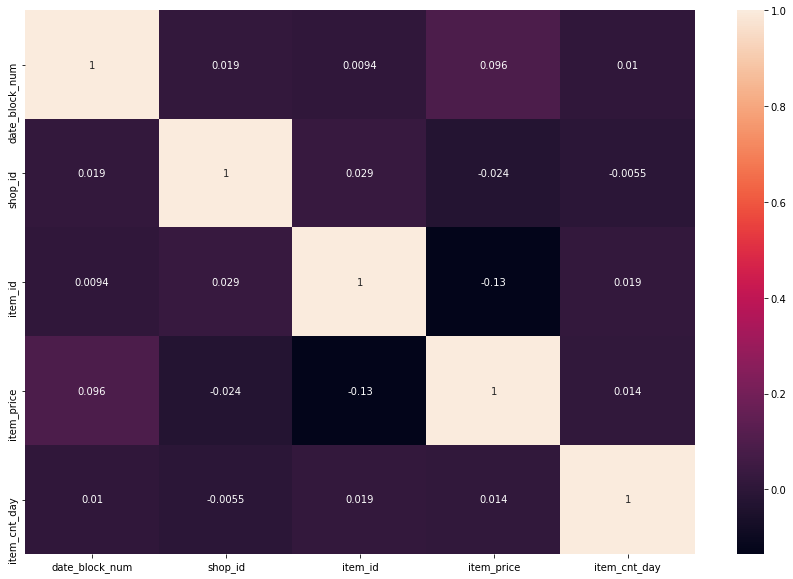

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(sales_train.corr(),annot=True)

Tried to check if there's any correlation between any features, but there's no coorelation and all the features are independent

###  Data Processing

#### Train Data

In [ ]:
sales_train['date'] = pd.to_datetime(sales_train.date,format="%d.%m.%Y")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [ ]:
# Pivot the data by month
pivot_df = sales_train.pivot_table(index=['shop_id','item_id'], 
                            columns='date_block_num', 
                            values='item_cnt_day',
                            aggfunc='sum').fillna(0.0)
pivot_df.head()

date_block_num    0     1    2    3    4    5   ...   28   29   30   31   32   33
shop_id item_id                                 ...                              
0       30       0.0  31.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        31       0.0  11.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        32       6.0  10.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        33       3.0   3.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
        35       1.0  14.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 34 columns]

In [ ]:
# Convert id values to string
train_data = pivot_df.reset_index()
train_data['shop_id']= train_data.shop_id.astype('str')
train_data['item_id']= train_data.item_id.astype('str')

# Join with categories
item_to_category = items.merge(item_categories[['item_category_id','Category']], 
                                how="inner", 
                                on="item_category_id")[['item_id','Category']]
item_to_category[['item_id']] = item_to_category.item_id.astype('str')

train_data = train_data.merge(item_to_category, how="inner", on="item_id")
train_data.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,Category
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Movie
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Movie


In [ ]:
# Encode Categories
from sklearn import preprocessing

LabelEncoder = preprocessing.LabelEncoder()
train_data[['Category']] = LabelEncoder.fit_transform(train_data.Category)
train_data = train_data[['shop_id', 'item_id', 'Category'] + list(range(34))]
train_data.head()

,shop_id,item_id,Category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Test Data

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
test['shop_id']= test.shop_id.astype('str')
test['item_id']= test.item_id.astype('str')

# Merge the monthly item count data
test = test.merge(train_data, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
test.head()

,ID,shop_id,item_id,Category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Adjust the labels for item count columns
d = dict(zip(test.columns[4:], list(np.array(list(test.columns[4:])) - 1)))

test  = test.rename(d, axis = 1)
test.head()

,ID,shop_id,item_id,Category,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Drop columns from test data and get predictions
x_test = test.drop(['ID', -1], axis=1).values
print(x_test.shape)

(214200, 36)


#### Split Data


In [ ]:
# Create input features, leaving out last column
x_train = train_data.iloc[:, :-1].values
print(x_train.shape)
x_train[:3]

(424123, 36)


array([['0', '30', 7, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       ['1', '30', 7, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       ['2', '30', 7, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=object)

In [ ]:
# Create target to predict
y_train = train_data.iloc[:, -1].values
print(y_train.shape)

(424123,)


### Model 1 : Random Forest Regressor 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

Hyperparameter Tuning for Random Forest Regression

In [ ]:
param_rfr = [{ 'n_estimators' : [2,10,20,50,100],
              'max_depth': np.arange(3, 10),
              'max_leaf_nodes':[1,10,25,50,100]}]

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
rfr = RandomForestRegressor()
rfr_gs = GridSearchCV(rfr, param_rfr, cv=3, verbose=0).fit(x_train, y_train)

In [ ]:
rfr_gs_results = pd.DataFrame(rfr_gs.cv_results_)
rfr_gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039333,0.000824,0.000000,0.000000,3,1,2,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,175
1,0.042504,0.000342,0.000000,0.000000,3,1,10,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,144
2,0.044856,0.000368,0.000000,0.000000,3,1,20,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,146
3,0.054859,0.001129,0.000000,0.000000,3,1,50,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,145
4,0.075450,0.000855,0.000000,0.000000,3,1,100,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.688279,0.003886,0.016071,0.000260,9,100,2,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.468911,0.579236,0.392803,0.480317,0.076537,138
171,3.342390,0.020638,0.034818,0.000455,9,100,10,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.639926,0.699694,0.409233,0.582951,0.125237,95
172,6.630071,0.011527,0.060955,0.002098,9,100,20,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.657397,0.691873,0.441346,0.596872,0.110871,32
173,16.696956,0.099573,0.129655,0.004730,9,100,50,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.665641,0.706143,0.449376,0.607053,0.112714,3


In [ ]:
print("Best Params", rfr_gs.best_params_)
print("Best Score", rfr_gs.best_score_)

Best Params {'max_depth': 7, 'max_leaf_nodes': 10, 'n_estimators': 10}
Best Score 0.6126751220897042


Tried training and predicting the model using the Best parameters but the rank after submission was pretty low so I tried tuned to hyperparameters to get a better rank on submission




In [ ]:
rfr = RandomForestRegressor(max_depth= 20, max_leaf_nodes= 500, n_estimators= 50)
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=500,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rfr_pred = rfr.predict(x_test).clip(0.,20.0)

pred1 = pd.DataFrame(rfr_pred, columns=['item_cnt_month'])
pred1

,item_cnt_month
0,0.521854
1,0.250909
2,0.796970
3,0.585724
4,0.250909
...,...
214195,0.400283
214196,0.067329
214197,0.144421
214198,0.067329


In [ ]:
pred1.to_csv('submission1.csv',index_label='ID')

### Model 2 : XGBoost

In [ ]:
import xgboost as xgb
param = {'max_depth':8,
         'subsample':1,  
         'min_child_weight':0.5,  # 0.5
         'eta':0.3,
         'num_round':1000, 
         'seed':0,  # 1
         'silent':0,
         'eval_metric':'rmse',
         'early_stopping_rounds':100
        }

progress = dict()
xgbtrain = xgb.DMatrix(x_train, y_train)
watchlist  = [(xgbtrain,'train-rmse')]
bst = xgb.train(param, xgbtrain)

In [ ]:
from sklearn.metrics import mean_squared_error 

preds = bst.predict(xgb.DMatrix(x_test))

In [ ]:
# Clip to values 0 - 20 and create submission file
pred2 = pd.DataFrame({'ID':test.ID, 'item_cnt_month': preds.clip(0. ,20.)})
pred2.to_csv('submission2.csv',index=False)

In [ ]:
pred2

,ID,item_cnt_month
0,0,0.417601
1,1,0.168167
2,2,0.656584
3,3,0.183587
4,4,0.168167
...,...,...
214195,214195,0.209859
214196,214196,0.163568
214197,214197,0.074748
214198,214198,0.163568


### Evaluation

We trained the model using two different models, and the submission is evaluated by root mean squared error.

- **mean_squared_error** : It tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. It’s called the mean squared error as you’re finding the average of a set of errors.

**Random Forest Regression :** 

I used GridSearch CV to get the best parameter combination and training the model using those parameters. After I submitted those results on Kaggle the score was really bad, so I tuned the parameters even more 

Parameter combination : <I>Best Params (max_depth= 20, max_leaf_nodes= 500, n_estimators= 50)</I>

**XGBoost :**

I trained the model using the below mentioned parameters, I got the best score using these parameters.

Parameter combination : <I>{'max_depth':8,
         'subsample':1,  
         'min_child_weight':0.5,  # 0.5
         'eta':0.3,
         'num_round':1000, 
         'seed':0,  # 1
         'silent':0,
         'eval_metric':'rmse',
         'early_stopping_rounds':100
        } </I>


### Summary

I can use standard scaler such as MinMaxScaler or OneHotEncoder to reform all the training and the testing data to one scale, which would make the training of the model more accurate upto a point. Moreoever using GridSearch or RandomSearch with more parameter can lead to trying more combinations which in turn could increase the accuracy of the predicting model. Atlast using regressor model can give decent score in the leaderboard but using deep learning models such as Neural Network or Long Short Term Model which particarly deal with time series data can gurantee a high accuracy score with better standing in the leaderboard.

###Contribution Statement

I used basic Random forest regressor model and default parameters, and got a decent ranking of 54% before I improved it using other models. I also used GridSearch CV to tuned the hyperparameter